In [24]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier

In [2]:

df_reviews = pd.read_csv('data/amazon_review_ID.shuf.lrn.csv')

In [3]:
display(df_reviews.info())
reviews_classes = df_reviews['Class'].unique()
print(reviews_classes, len(reviews_classes))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750 entries, 0 to 749
Columns: 10002 entries, ID to Class
dtypes: int64(10001), object(1)
memory usage: 57.2+ MB


None

['Shea' 'Riley' 'Chachra' 'Agresti' 'Nigam' 'Messick' 'Cutey' 'Mitchell'
 'Ashbacher' 'Brody' 'Vernon' 'Goonan' 'Harp' 'Lovitt' 'Corn' 'Engineer'
 'Calvinnme' 'Chell' 'Comdet' 'Kolln' 'Peterson' 'Dent' 'Wilson' 'Mark'
 'Grove' 'Janson' 'Brown' 'Auken' 'Sherwin' 'Cholette' 'McKee' 'Taylor'
 'Walters' 'Merritt' 'Blankenship' 'Chandler' 'Johnson' 'Hayes' 'Koenig'
 'CFH' 'Lawyeraau' 'Davisson' 'Mahlers2nd' 'Power' 'Robert' 'Morrison'
 'Lee' 'Neal' 'Bukowsky' 'Vision'] 50


ID        0
V1        0
V2        0
V3        0
V4        0
         ..
V9997     0
V9998     0
V9999     0
V10000    0
Class     0
Length: 10002, dtype: int64

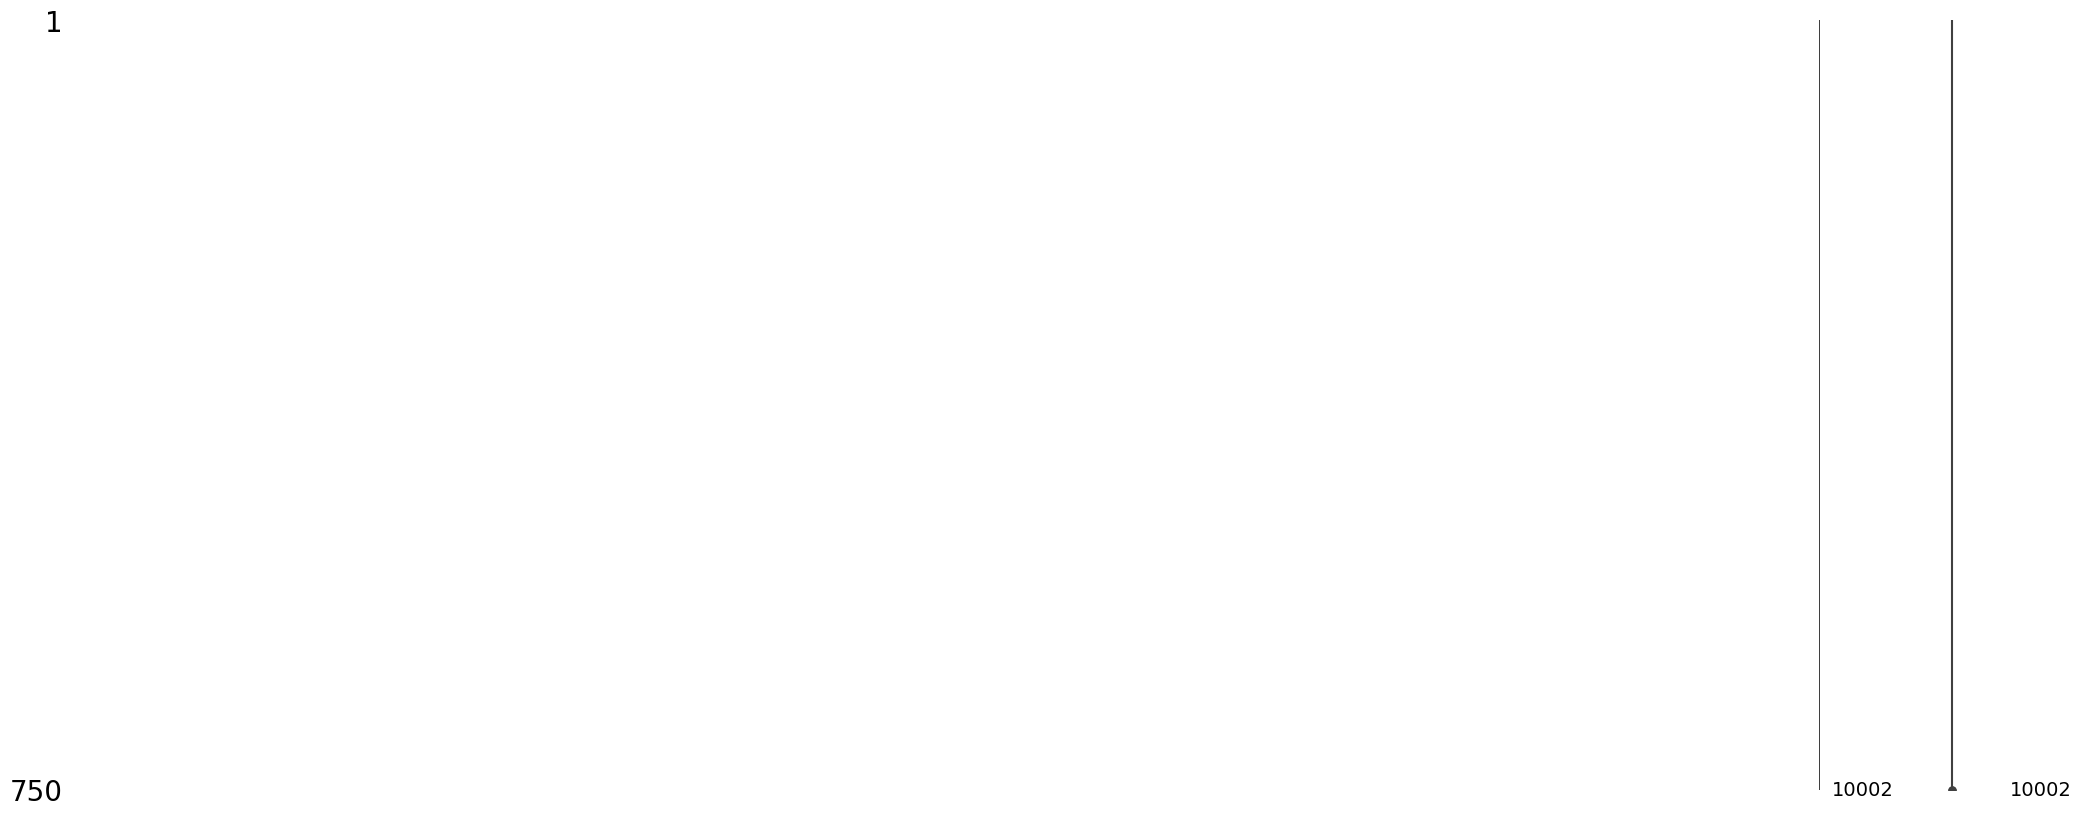

In [4]:
msno.matrix(df_reviews)
df_reviews.isna().sum()

In [ ]:
df_reviews_num = df_reviews.drop(['ID', 'Class'], axis=1)
Q1_rev = df_reviews_num.quantile(0.25)
Q3_rev = df_reviews_num.quantile(0.75)
IQR_rev = Q3_rev - Q1_rev

IQR_outliers_rev = df_reviews_num[((df_reviews_num < (Q1_rev - 1.5 * IQR_rev)) | (df_reviews_num > (Q3_rev + 1.5 * IQR_rev))).any(axis=1)]
display(IQR_outliers_rev.head(5))
display(IQR_outliers_rev.info())

In [ ]:
z_scores_rev = stats.zscore(df_reviews_num)
abs_z_scores_rev = np.abs(z_scores_rev)
filtered_entries_rev = (abs_z_scores_rev < 3).all(axis=1)

df_reviews_Z = df_reviews[filtered_entries_rev]
display(df_reviews_Z.info(verbose=True))

# Feature Selection

In a scenario with many features and limited samples, performing feature selection makes a lot of sense. It can help optimize our model, improve its performance.

In [27]:
X_train = df_reviews.drop(['ID', 'Class'], axis=1)
y_train = df_reviews['Class']
print("Shape of X (features):", X.shape)
print("Shape of y (target):", y.shape)

Shape of X (features): (750, 10000)
Shape of y (target): (750,)


# Univariate Selection:
statistical tests (like Chi-squared tests for categorical data or F-tests for continuous variables) to select features with the strongest relationship to the target variable.

In [16]:
from sklearn.feature_selection import SelectKBest, chi2

# Choose the top k features based on univariate statistical tests
selector = SelectKBest(score_func=chi2, k=100)  # Change k as needed
X_new = selector.fit_transform(X, y)
X_new.shape

(750, 100)

In [32]:
# Identify constant features
constant_features = [col for col in X_train.columns if X_train[col].nunique() == 1]
constant_features
# Drop constant features
X_train = X_train.drop(columns=constant_features)
print(f"Removed constant features: {constant_features}")

Removed constant features: []


In [34]:
# Check for NaN values
print(X_train.isnull().sum())

# Check for infinite values
print(np.isinf(X_train).sum())

V1        0
V2        0
V3        0
V4        0
V5        0
         ..
V9996     0
V9997     0
V9998     0
V9999     0
V10000    0
Length: 10000, dtype: int64
V1        0
V2        0
V3        0
V4        0
V5        0
         ..
V9996     0
V9997     0
V9998     0
V9999     0
V10000    0
Length: 10000, dtype: int64


In [45]:
from sklearn.feature_selection import VarianceThreshold

# Remove features with variance below a certain threshold
sel = VarianceThreshold(threshold=0.05)
X_train_filtered = sel.fit_transform(X_train)
print(X_train_filtered)

# Get the columns that were retained
retained_columns = X_train.columns[sel.get_support()]
X_train_filtered = pd.DataFrame(X_train_filtered, columns=retained_columns)

[[17  4  8 ...  0  1  1]
 [21  9  5 ...  0  1  0]
 [ 9  7  6 ...  0  1  1]
 ...
 [13  8  6 ...  1  0  0]
 [14 16  7 ...  0  0  0]
 [12 11  7 ...  0  0  0]]


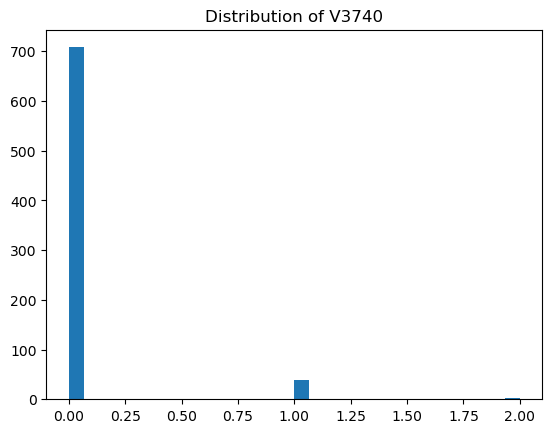

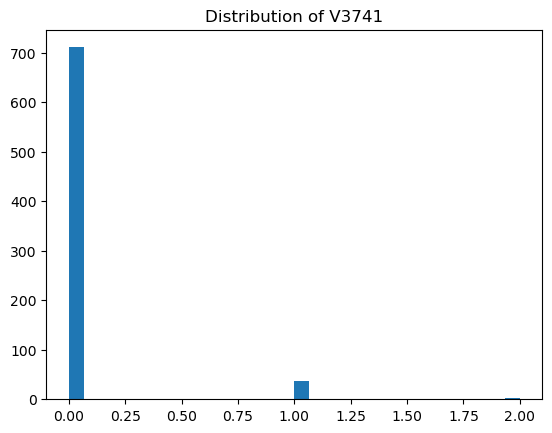

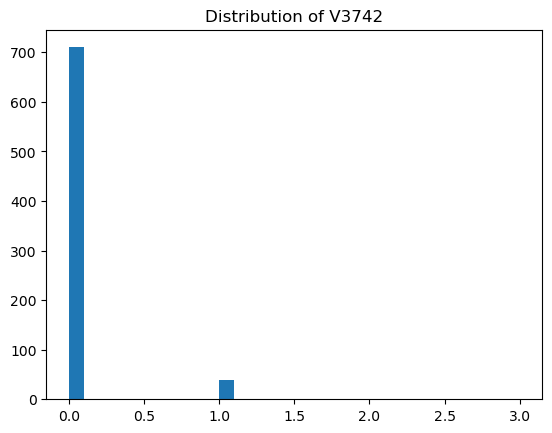

In [47]:
import matplotlib.pyplot as plt

# Plot distribution of a few features
for column in X_train_filtered.columns[1000:1003]:
    plt.hist(X_train[column], bins=30)
    plt.title(f'Distribution of {column}')
    plt.show()

# Recursive Feature Elimination (RFE):
This method recursively removes the least important features based on the model's performance until the specified number of features is reached.

In [17]:
from sklearn.feature_selection import RFE

model = RandomForestClassifier(random_state=42)


In [ ]:
#############!!!! runs very long !!!!! #################
rfe = RFE(model, n_features_to_select=100)  
X_rfe = rfe.fit_transform(X, y)

# Feature Importance from Tree-based Models:
Models like Random Forest or Gradient Boosting provide feature importance scores which can be used to select the top features.

In [18]:
model.fit(X, y)
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

# Select top features
X_selected = X_train.iloc[:, indices[:100]] 
X_selected

,V6629,V6924,V1379,V1405,V4377,V6707,V6597,V1381,V6793,V4380,...,V6581,V12,V6576,V6636,V6616,V106,V2,V4426,V7009,V5389
0,5,1,0,0,0,6,16,0,1,0,...,19,0,26,4,11,0,4,0,2,0
1,7,1,0,0,0,0,10,0,2,0,...,46,3,27,9,5,0,9,0,1,0
2,6,1,0,0,0,0,7,0,2,0,...,24,2,28,5,5,0,7,0,0,0
3,21,1,0,0,0,11,12,0,3,0,...,18,2,30,3,8,0,3,0,1,0
4,13,0,0,0,0,2,3,0,0,0,...,28,2,32,8,12,0,8,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745,3,1,0,0,0,5,7,0,1,0,...,19,5,38,1,3,4,1,0,0,0
746,12,0,0,0,0,5,19,0,0,0,...,29,0,67,6,13,0,7,0,1,0
747,5,2,0,0,0,6,17,0,3,0,...,16,6,28,8,11,0,8,0,2,0
748,9,0,0,0,0,6,3,0,0,0,...,44,10,28,15,15,0,16,0,8,0


# Principal Component Analysis (PCA)
If we want to reduce dimensionality while retaining variance, PCA can be a good choice. It transforms the features into a set of linear combinations.

In [51]:
from sklearn.decomposition import PCA
pca = PCA(n_components=100)  
X_pca = pca.fit_transform(X_train)
X_pca.shape

(750, 100)

# Which machine learning algorithm should we choose
Random Forest or XGBoost can handle high-dimensional data effectively. 
 We could also try other models like SVM or neural networks, but there is a risk of overfitting given the dataset's size.

In [20]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [26]:
model = SVC(kernel='linear')  # also try other kernels like 'rbf'
model.fit(X_train, y_train)

SVC(kernel='linear')